In [69]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as k_image
from matplotlib import image
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Activation
from tensorflow.keras.models import Model
import rasterio
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


path_jpg = 'archive/EuroSAT/'
path_tif = 'archive/EuroSATallBands/'

In [2]:
# dataset = image_dataset_from_directory(path, labels = "inferred", label_mode = 'categorical', image_size = (64, 64))

In [3]:
train_df_jpg = pd.read_csv(path_jpg + 'train.csv')
val_df_jpg = pd.read_csv(path_jpg + 'validation.csv')
test_df_jpg = pd.read_csv(path_jpg + 'test.csv')

train_files_jpg = train_df_jpg.Filename
val_files_jpg = val_df_jpg.Filename
test_files_jpg = test_df_jpg.Filename

train_labels_jpg = train_df_jpg.Label
val_labels_jpg = val_df_jpg.Label
test_labels_jpg = test_df_jpg.Label

In [4]:
train_df_tif = pd.read_csv(path_tif + 'train.csv')
val_df_tif = pd.read_csv(path_tif + 'validation.csv')
test_df_tif = pd.read_csv(path_tif + 'test.csv')

train_files_tif = train_df_tif.Filename
val_files_tif = val_df_tif.Filename
test_files_tif = test_df_tif.Filename

train_labels_tif = train_df_tif.Label
val_labels_tif = val_df_tif.Label
test_labels_tif = test_df_tif.Label

In [5]:
train_images_jpg = []
for file in train_files_jpg:
    Image = k_image.load_img(path_jpg + file)  
    image_arr = k_image.img_to_array(Image)
    train_images_jpg.append(image_arr)

val_images_jpg = []
for file in val_files_jpg:
    Image = k_image.load_img(path_jpg + file)  
    image_arr = k_image.img_to_array(Image)
    val_images_jpg.append(image_arr)

test_images_jpg = []
for file in test_files_jpg:
    Image = k_image.load_img(path_jpg + file)  
    image_arr = k_image.img_to_array(Image)
    test_images_jpg.append(image_arr)

In [6]:
# Path to the TIFF file
tif_file_path = 'archive/EuroSATallBands/AnnualCrop/AnnualCrop_1.tif'  # Replace with your file path

# Open the TIFF file using rasterio
with rasterio.open(tif_file_path) as dataset:
    # Allocate a NumPy array for the whole dataset
    data_array = np.empty((dataset.count, dataset.height, dataset.width), dtype=dataset.dtypes[0])

    # Read each band into the array
    for i in range(dataset.count):
        data_array[i, :, :] = dataset.read(i + 1)

# Transpose the array to get it into the desired shape (64, 64, 13)
data_array = data_array.transpose((1, 2, 0))

# Check the shape of the array
print(data_array.shape)  # This should print (64, 64, 13)


In [7]:
def processTif(fullPath):
    with rasterio.open(fullPath) as img:
        d_array = np.empty((5, img.height, img.width), dtype = img.dtypes[0])
        for i in range(5):
            d_array[i, :, :] = img.read(i + 1)

    return d_array.transpose((1, 2, 0))

In [8]:
train_images_tif = []
for file in train_files_tif:
    # Image = k_image.load_img(path_tif + file)  
    # image_arr = k_image.img_to_array(Image)
    train_images_tif.append(processTif(path_tif + file))

val_images_tif = [] 
for file in val_files_tif:
    # Image = k_image.load_img(path_tif + file)  
    # image_arr = k_image.img_to_array(Image)
    val_images_tif.append(processTif(path_tif + file))

test_images_tif = []
for file in test_files_tif:
    # Image = k_image.load_img(path_tif + file)  
    # image_arr = k_image.img_to_array(Image)
    test_images_tif.append(processTif(path_tif + file))

In [9]:
train_images_tif[0].shape

(64, 64, 5)

In [10]:
all_images_jpg = train_images_jpg + val_images_jpg
all_labels_jpg = np.array(list(train_labels_jpg) + list(val_labels_jpg))
test_labels_jpg = np.array(test_labels_jpg)

#normalization 
all_images_jpg = np.array(all_images_jpg) / 255.
test_images_jpg = np.array(test_images_jpg) / 255.

#one-hot encoding 
all_labels_jpg = to_categorical(all_labels_jpg, 10)
test_labels_jpg = to_categorical(test_labels_jpg, 10)

print(all_images_jpg.shape)
print(all_labels_jpg.shape)
print(test_images_jpg.shape)
print(test_labels_jpg.shape)

(24300, 64, 64, 3)
(24300, 10)
(2700, 64, 64, 3)
(2700, 10)


In [11]:
all_images_tif = train_images_tif + val_images_tif
all_labels_tif = np.array(list(train_labels_tif) + list(val_labels_tif))
test_labels_tif = np.array(test_labels_tif)

#normalization 
all_images_tif = np.array(all_images_tif) / 255.
test_images_tif = np.array(test_images_tif) / 255.

#one-hot encoding 
all_labels_tif = to_categorical(all_labels_tif, 10)
test_labels_tif = to_categorical(test_labels_tif, 10)

print(all_images_tif.shape)
print(all_labels_tif.shape)
print(test_images_tif.shape)
print(test_labels_tif.shape)

(24836, 64, 64, 5)
(24836, 10)
(2759, 64, 64, 5)
(2759, 10)


In [12]:
X_train_jpg, X_val_jpg, T_train_jpg, T_val_jpg = train_test_split(all_images_jpg, 
                                                                  all_labels_jpg, 
                                                                  test_size = 0.2, 
                                                                  shuffle = True, 
                                                                  stratify = all_labels_jpg, 
                                                                  random_state = 0)
print(X_train_jpg.shape)
print(T_train_jpg.shape)
print(X_val_jpg.shape)
print(T_val_jpg.shape)

(19440, 64, 64, 3)
(19440, 10)
(4860, 64, 64, 3)
(4860, 10)


In [13]:
X_train_tif, X_val_tif, T_train_tif, T_val_tif = train_test_split(all_images_tif, 
                                                                  all_labels_tif, 
                                                                  test_size = 0.2, 
                                                                  shuffle = True, 
                                                                  stratify = all_labels_tif, 
                                                                  random_state = 0)
print(X_train_tif.shape)
print(T_train_tif.shape)
print(X_val_tif.shape)
print(T_val_tif.shape)

(19868, 64, 64, 5)
(19868, 10)
(4968, 64, 64, 5)
(4968, 10)


In [14]:
# np.random.seed(0)

# aug = ImageDataGenerator(rotation_range = 15, width_shift_range = 0.2, height_shift_range = 0.2)

# X_train_generator = aug.flow(X_train, T_train, batch_size = 32, save_format = 'jpeg')

In [15]:
resnet50_jpg = ResNet50(weights = 'imagenet', include_top = False, input_shape = (64, 64, 3))

In [16]:
resnet50_tif = ResNet50(weights = None, include_top = False, input_shape = (64, 64, 5))

C:\ProgramData\anaconda3\envs\CES\lib\site-packages\keras\applications\resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 5 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [17]:
len(resnet50_jpg.layers), len(resnet50_tif.layers)

(175, 175)

In [18]:
fine_tune_at = len(resnet50_jpg.layers) - 5
for layer in resnet50_jpg.layers[:fine_tune_at]:
    layer.trainable = False

In [19]:
fine_tune_at = len(resnet50_tif.layers) - 5
for layer in resnet50_tif.layers[:fine_tune_at]:
    layer.trainable = False

In [20]:
x_jpg = resnet50_jpg.output
x_tif = resnet50_tif.output

In [21]:
x_jpg = Flatten()(x_jpg)
x_jpg = Dropout(0.2)(x_jpg)
x_jpg = Dense(256, activation = 'leaky_relu')(x_jpg)
x_jpg = Dropout(0.2)(x_jpg)
x_jpg = Dense(128, activation = 'leaky_relu')(x_jpg)
x_jpg = Dropout(0.2)(x_jpg)
x_jpg = Dense(64, activation = 'leaky_relu')(x_jpg)
x_jpg = Dropout(0.2)(x_jpg)
x_jpg = Dense(32, activation = 'leaky_relu')(x_jpg)
x_jpg = Dropout(0.2)(x_jpg)
x_jpg = Dense(10, activation = 'softmax')(x_jpg)

In [22]:
x_tif = Flatten()(x_tif)
x_tif = Dropout(0.2)(x_tif)
x_tif = Dense(256, activation = 'leaky_relu')(x_tif)
x_tif = Dropout(0.2)(x_tif)
x_tif = Dense(128, activation = 'leaky_relu')(x_tif)
x_tif = Dropout(0.2)(x_tif)
x_tif = Dense(64, activation = 'leaky_relu')(x_tif)
x_tif = Dropout(0.2)(x_tif)
x_tif = Dense(32, activation = 'leaky_relu')(x_tif)
x_tif = Dropout(0.2)(x_tif)
x_tif = Dense(10, activation = 'softmax')(x_tif)

In [33]:
resnet50_jpg_model = Model(inputs = resnet50_jpg.input, outputs = x_jpg)
resnet50_tif_model = Model(inputs = resnet50_tif.input, outputs = x_tif)

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "resnet__train/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(checkpoint_path, verbose = 1, save_weights_only = True, save_freq = 1)
checkpoint_callback_jpg = keras.callbacks.ModelCheckpoint('Eurosat_3_Bands.h5', save_best_only=True)
checkpoint_callback_tif = keras.callbacks.ModelCheckpoint('Eurosat_All_Bands.h5', save_best_only=True)

In [35]:
resnet50_jpg_model.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.001, nesterov = True), 
                       loss = 'categorical_crossentropy', 
                       metrics = ['accuracy'])

resnet50_tif_model.compile(optimizer = keras.optimizers.SGD(learning_rate = 0.001, nesterov = True), 
                       loss = 'categorical_crossentropy', 
                       metrics = ['accuracy'])

In [36]:
history_jpg = resnet50_jpg_model.fit(X_train_jpg, 
                                     T_train_jpg, 
                                     validation_data = (X_val_jpg, T_val_jpg), 
                                     epochs = 50,
                                     batch_size = 128,
                                     callbacks = [checkpoint_callback_jpg])

Epoch 1/50
152/152 [==============================] - 112s 719ms/step - loss: 1.7051 - accuracy: 0.3757 - val_loss: 1.5586 - val_accuracy: 0.4202
Epoch 2/50
152/152 [==============================] - 110s 724ms/step - loss: 1.6815 - accuracy: 0.3887 - val_loss: 1.5259 - val_accuracy: 0.4418
Epoch 3/50
152/152 [==============================] - 108s 709ms/step - loss: 1.6584 - accuracy: 0.3883 - val_loss: 1.5107 - val_accuracy: 0.4514
Epoch 4/50
152/152 [==============================] - 109s 718ms/step - loss: 1.6509 - accuracy: 0.3918 - val_loss: 1.4944 - val_accuracy: 0.4568
Epoch 5/50
152/152 [==============================] - 107s 706ms/step - loss: 1.6359 - accuracy: 0.3957 - val_loss: 1.4850 - val_accuracy: 0.4391
Epoch 6/50
152/152 [==============================] - 109s 719ms/step - loss: 1.6190 - accuracy: 0.4042 - val_loss: 1.4957 - val_accuracy: 0.4210
Epoch 7/50
152/152 [==============================] - 109s 719ms/step - loss: 1.6071 - accuracy: 0.4126 - val_loss: 1.4606 -

In [38]:
history_tif = resnet50_tif_model.fit(X_train_tif, 
                                     T_train_tif, 
                                     validation_data = (X_val_tif, T_val_tif), 
                                     epochs = 100, 
                                     batch_size = 128,
                                     callbacks = [checkpoint_callback_tif])

Epoch 1/100
156/156 [==============================] - 122s 773ms/step - loss: 1.0809 - accuracy: 0.6205 - val_loss: 0.9082 - val_accuracy: 0.6800
Epoch 2/100
156/156 [==============================] - 112s 721ms/step - loss: 1.0669 - accuracy: 0.6264 - val_loss: 0.9093 - val_accuracy: 0.6886
Epoch 3/100
156/156 [==============================] - 113s 725ms/step - loss: 1.0739 - accuracy: 0.6244 - val_loss: 0.9007 - val_accuracy: 0.6820
Epoch 4/100
156/156 [==============================] - 114s 730ms/step - loss: 1.0636 - accuracy: 0.6278 - val_loss: 0.8920 - val_accuracy: 0.6896
Epoch 5/100
156/156 [==============================] - 113s 727ms/step - loss: 1.0642 - accuracy: 0.6237 - val_loss: 0.8898 - val_accuracy: 0.6878
Epoch 6/100
156/156 [==============================] - 114s 734ms/step - loss: 1.0566 - accuracy: 0.6302 - val_loss: 0.8967 - val_accuracy: 0.6872
Epoch 7/100
156/156 [==============================] - 113s 727ms/step - loss: 1.0438 - accuracy: 0.6328 - val_loss: 0

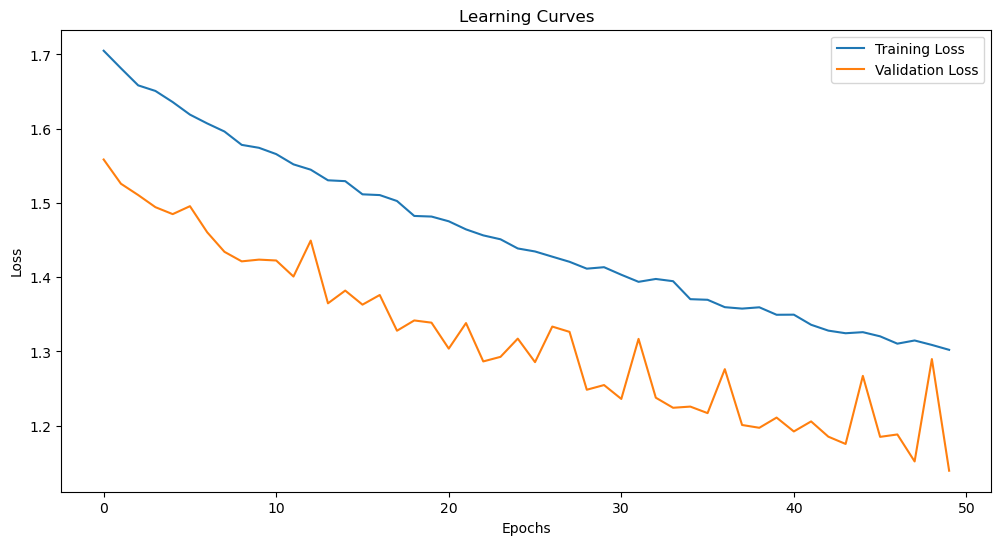

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(history_jpg.history['loss'], label='Training Loss')
plt.plot(history_jpg.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

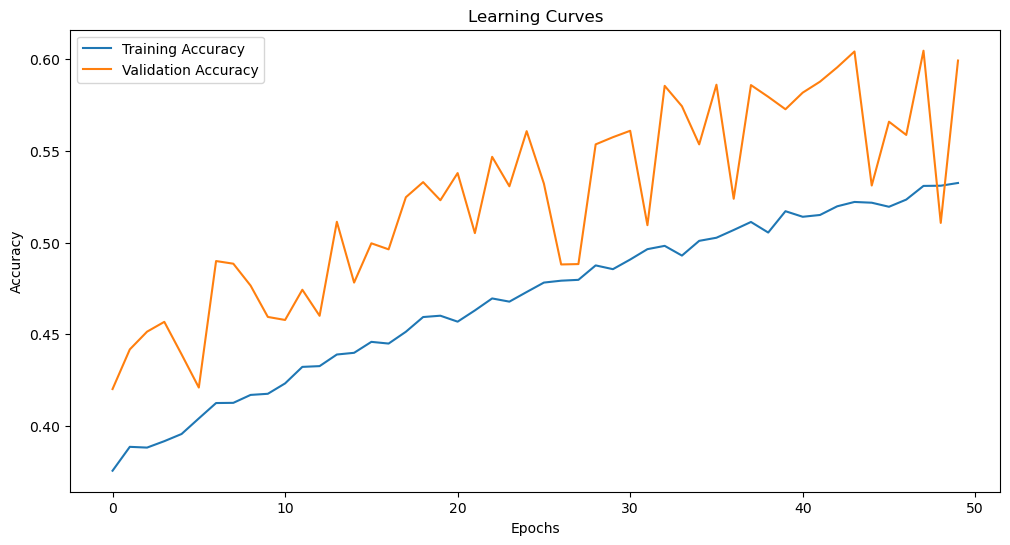

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(history_jpg.history['accuracy'], label='Training Accuracy')
plt.plot(history_jpg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

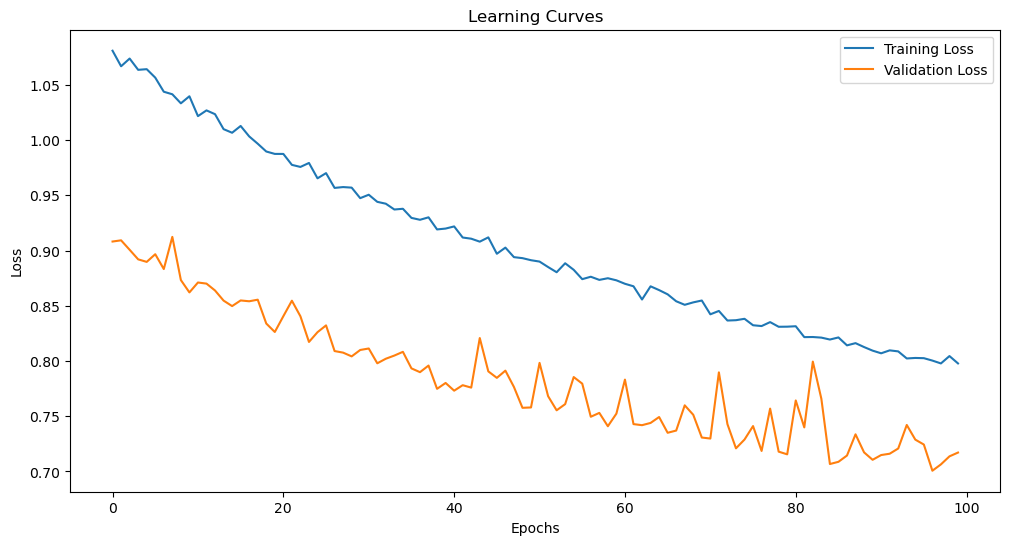

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(history_tif.history['loss'], label='Training Loss')
plt.plot(history_tif.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

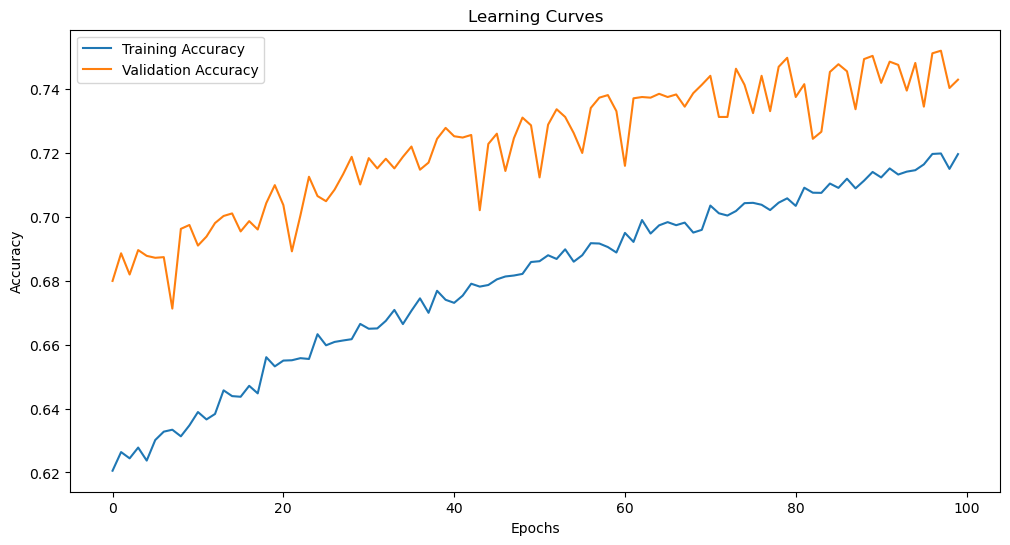

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(history_tif.history['accuracy'], label='Training Accuracy')
plt.plot(history_tif.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
pred_jpg = resnet50_jpg_model.predict(test_images_jpg)

85/85 [==============================] - 18s 171ms/step


In [54]:
y_jpg = []
for pred in pred_jpg:
    y_jpg.append(np.argmax(pred))

y_jpg = np.array(y_jpg)

t_jpg = []
for t in test_labels_jpg:
    t_jpg.append(np.argmax(t))

t_jpg = np.array(t_jpg)

In [55]:
print(classification_report(y_jpg, t_jpg))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       309
           1       0.81      0.69      0.74       352
           2       0.47      0.44      0.45       321
           3       0.34      0.33      0.33       258
           4       0.85      0.83      0.84       256
           5       0.21      0.43      0.28        98
           6       0.36      0.43      0.39       208
           7       0.82      0.80      0.81       306
           8       0.29      0.33      0.31       221
           9       0.91      0.74      0.81       371

    accuracy                           0.60      2700
   macro avg       0.57      0.57      0.57      2700
weighted avg       0.63      0.60      0.61      2700



[[207   0  12  25   1  12  23   0  22   7]
 [  2 242  34   2   0  43   2   0  19   8]
 [  6   1 140  17   0  55  45  21  34   2]
 [ 29   0  20  85  11   2  35   8  68   0]
 [  2   0   8   9 213   0  10   9   5   0]
 [ 12   1  13  10   0  42   5   0  11   4]
 [ 10   0  34  35  12   1  90  16  10   0]
 [  0   0  16  11  13   0  18 246   2   0]
 [ 23   1  19  53   0  24  22   0  73   6]
 [  9  55   4   3   0  21   0   0   6 273]]


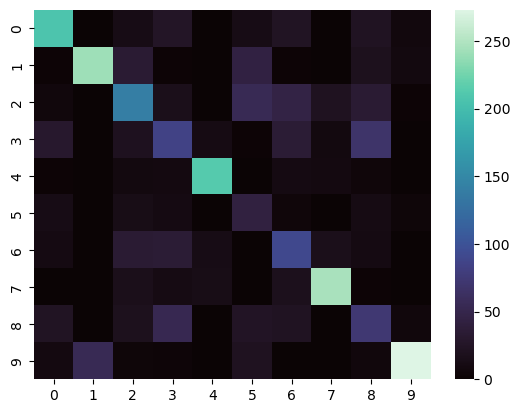

In [79]:
print(confusion_matrix(y_jpg, t_jpg))
sns.heatmap(confusion_matrix(y_jpg, t_jpg), cmap='mako')
plt.show()

In [80]:
pred_tif = resnet50_tif_model.predict(test_images_tif)

87/87 [==============================] - 19s 176ms/step


In [81]:
y_tif = []
for pred in pred_tif:
    y_tif.append(np.argmax(pred))

y_tif = np.array(y_tif)

t_tif = []
for t in test_labels_tif:
    t_tif.append(np.argmax(t))

t_tif = np.array(t_tif)

In [83]:
print(classification_report(y_tif, t_tif))

              precision    recall  f1-score   support

           0       0.89      0.57      0.70       468
           1       0.95      0.95      0.95       300
           2       0.54      0.65      0.59       250
           3       0.38      0.52      0.44       183
           4       0.89      0.89      0.89       250
           5       0.80      0.75      0.77       214
           6       0.50      0.48      0.49       260
           7       0.76      0.85      0.80       271
           8       0.66      0.78      0.72       212
           9       0.96      0.99      0.97       351

    accuracy                           0.75      2759
   macro avg       0.73      0.74      0.73      2759
weighted avg       0.77      0.75      0.75      2759



[[268   0  34  60   0   7  67   0  27   5]
 [  2 284   5   2   0   3   0   0   1   3]
 [  5   2 163   8   2  26  37   6   1   0]
 [  2   0  16  96   6   1  14  19  29   0]
 [  0   0   1   9 222   0   0  17   1   0]
 [  6  14   4  10   0 160   4   0  16   0]
 [ 14   0  69  22   6   1 125  22   1   0]
 [  0   0   6  16  12   1   3 229   4   0]
 [  3   0   2  27   1   1   0   7 166   5]
 [  0   0   0   0   1   0   0   0   4 346]]


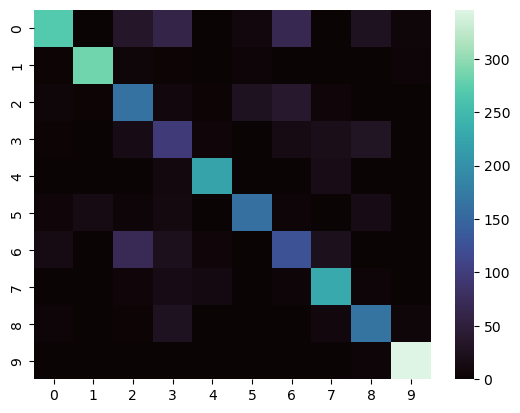

In [84]:
print(confusion_matrix(y_tif, t_tif))
sns.heatmap(confusion_matrix(y_tif, t_tif), cmap='mako')
plt.show()